## import the library

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

## Data load & Visualization

In [2]:
movies = pd.read_csv('ml-25m/movies.csv')
ratings = pd.read_csv('ml-25m/ratings.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [6]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

## 평점 분포

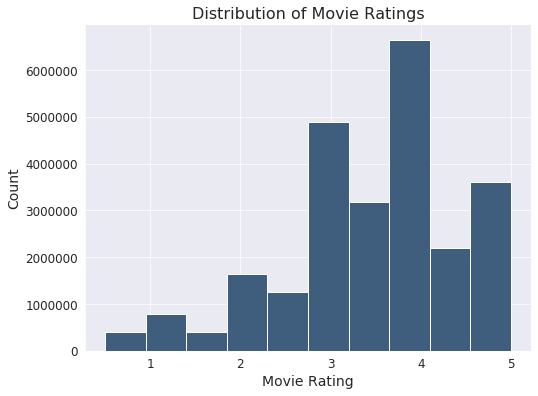

In [100]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

# 데이터프레임에서 한 컬럼만 뽑아낸 시리즈를 종류별로 카운트하고, 인덱스에 따라 내림차순 정렬
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.set_title("Distribution of Movie Ratings", fontsize=16)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
  
plt.xlabel("Movie Rating", fontsize=14)  
plt.ylabel("Count", fontsize=14)  
  
plt.hist(ratings['rating'], color="#3F5D7D")  

plt.show()

## 평점의 개수 분포

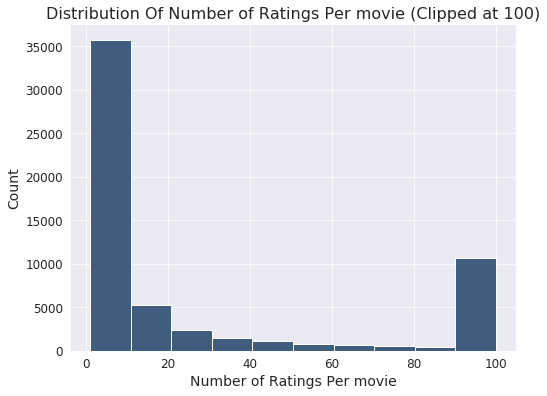

In [104]:
# 영화 한 편당 평점 개수. groupby 함수로 카운팅한다.
data = ratings.groupby('movieId')['rating'].count().clip(upper=100)


plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.set_title('Distribution Of Number of Ratings Per movie (Clipped at 100)', fontsize=16)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
  
plt.xlabel('Number of Ratings Per movie', fontsize=14)  
plt.ylabel("Count", fontsize=14)  
  
plt.hist(data.values, color="#3F5D7D")  

plt.show()


In [9]:
ratings.groupby('movieId')['rating'].count().reset_index().sort_values('rating', ascending=True)[:80]

,movieId,rating
29523,136782,1
34959,151011,1
34958,151001,1
34951,150962,1
34947,150950,1
...,...,...
34839,150651,1
34838,150649,1
34860,150708,1
34765,150385,1


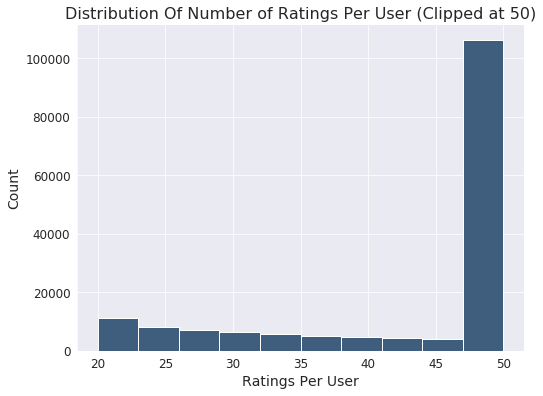

"# trace 생성하기.\ntrace = go.Histogram(x = data.values,\n                     name = 'Ratings',\n                     xbins = dict(start = 0,\n                                  end = 50,\n                                  size = 2))\n# 레이아웃 생성하기.\nlayout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',\n                   xaxis = dict(title = 'Ratings Per User'),\n                   yaxis = dict(title = 'Count'),\n                   bargap = 0.2)\n\n# Create plot\nfig = go.Figure(data=[trace], layout=layout)\niplot(fig)"

In [103]:
# 사용자별 평점 개수
data = ratings.groupby('userId')['rating'].count().clip(upper=50)


plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.set_title('Distribution Of Number of Ratings Per User (Clipped at 50)', fontsize=16)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
  
plt.xlabel('Ratings Per User', fontsize=14)  
plt.ylabel("Count", fontsize=14)  
  
plt.hist(data.values, color="#3F5D7D")  

plt.show()

## Data  정제

In [11]:
#ratings에서 timestamp행은 사용하지 않으므로 삭제
del(ratings['timestamp'])

In [12]:
movies['title'] = movies['title'].astype('str')
movies['title'].dtype

dtype('O')

In [13]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [14]:
movies['title_no_year'] = movies['title'].str.slice(start=0,stop=-7)
movies

,movieId,title,genres,title_no_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II
...,...,...,...,...
62418,209157,We (2018),Drama,We
62419,209159,Window of the Soul (2001),Documentary,Window of the Soul
62420,209163,Bad Poems (2018),Comedy|Drama,Bad Poems
62421,209169,A Girl Thing (2001),(no genres listed),A Girl Thing


## 제목길이가 7이하인 movies 확인

In [15]:
np.unique(movies['title_no_year'],return_counts = True)

(array(['', '"BLOW THE NIGHT!" Let\'s Spend the Night Together',
        '"Great Performances" Cats', ..., 'チェブラーシカ', '貞子3D', '줄탁동시'],
       dtype=object),
 array([44,  1,  1, ...,  1,  1,  1]))

In [16]:
movies['len'] = movies['title'].str.len()

In [17]:
movies['len'].describe()

count    62423.000000
mean        25.424267
std         11.730151
min          2.000000
25%         18.000000
50%         23.000000
75%         29.000000
max        191.000000
Name: len, dtype: float64

## drop할 무비 목록 정리

In [18]:
tmp_movies = movies[movies['len']<=7]
drop_idx = movies[movies['len']<=7].index

In [19]:
movies.drop(drop_idx,inplace= True)
movies['len'].describe()

count    62379.000000
mean        25.438160
std         11.722553
min          8.000000
25%         18.000000
50%         23.000000
75%         29.000000
max        191.000000
Name: len, dtype: float64

In [20]:
#길이가 7 이상인 영화에 대해서만 제목을 자름
movies['title'] = movies['title'].str.slice(start=0,stop=-7)

In [21]:
#길이가 7이하였던 영화들을 다시 포함
movies.append(tmp_movies)
movies

,movieId,title,genres,title_no_year,len
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,16
1,2,Jumanji,Adventure|Children|Fantasy,Jumanji,14
2,3,Grumpier Old Men,Comedy|Romance,Grumpier Old Men,23
3,4,Waiting to Exhale,Comedy|Drama|Romance,Waiting to Exhale,24
4,5,Father of the Bride Part II,Comedy,Father of the Bride Part II,34
...,...,...,...,...,...
62418,209157,We,Drama,We,9
62419,209159,Window of the Soul,Documentary,Window of the Soul,25
62420,209163,Bad Poems,Comedy|Drama,Bad Poems,16
62421,209169,A Girl Thing,(no genres listed),A Girl Thing,19


In [22]:
movies.columns

Index(['movieId', 'title', 'genres', 'title_no_year', 'len'], dtype='object')

In [23]:
del(movies['title_no_year'])
del(movies['len'])

In [24]:
del(tmp_movies)

In [25]:
movies['title'].duplicated().sum()

3867

## train_test_split for item2vec

In [31]:
#min_movie_ratings = ratings.groupby('userId')['rating'].count().quantile(0.7)

filter_movies = ratings['movieId'].value_counts() >= 10
filter_movies = filter_movies[filter_movies].index.tolist()

ratings_new = ratings[ratings['movieId'].isin(filter_movies)]
print('The original data frame shape:\t{}'.format(ratings.shape))
print('The new data frame shape:\t{}'.format(ratings_new.shape))

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



The original data frame shape:	(25000095, 3)
The new data frame shape:	(17423056, 3)


In [33]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test= train_test_split(ratings_new,
                                            stratify=ratings_new['userId'],
                                            random_state = 112224,
                                            test_size=0.30)

print("Number of training data: "+str(len(ratings_train)))
print("Number of test data: "+str(len(ratings_test)))

Number of training data: 12196139
Number of test data: 5226917


## SVD

In [38]:
#SVD has different train_test_split, so i apply another train_test_split 
from surprise.model_selection import train_test_split as tts
reader = Reader()

#make the surprise dataset and bulid_full_trainset
#but in the suprise train_test_split it's automatic
data = Dataset.load_from_df(ratings_new[['userId', 'movieId', 'rating']][:], reader)
train, test = tts(data,test_size=0.3, random_state= 112224)

#data.split(n_folds=3)

'''train = Dataset.load_from_df(ratings_train[['userId', 'movieId', 'rating']][:], reader)
reader = Reader()
test = Dataset.load_from_df(ratings_test[['userId', 'movieId', 'rating']][:], reader)'''


"train = Dataset.load_from_df(ratings_train[['userId', 'movieId', 'rating']][:], reader)\nreader = Reader()\ntest = Dataset.load_from_df(ratings_test[['userId', 'movieId', 'rating']][:], reader)"

In [39]:
algo = SVD(random_state=112224)

algo.fit(train)

#cross_validate(svd, data, measures=['RMSE', 'MAE'],cv=5,return_train_measures=True,verbose=True)

In [41]:
predictions = algo.test(test)
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 0.8055


0.8054583532133616

## SVD 성능평가

In [43]:
#SVD predict the rates so we can compute the loss
#so calculate the mae & rmse loss 
print('the loss of mae : {}'.format(accuracy.mae(predictions,verbose = False)))
print('the loss of rmse : {}'.format(accuracy.rmse(predictions,verbose=False)))

the loss of mae : 0.6097518724292804
the loss of rmse : 0.8054583532133616


In [82]:
#acc
accuracy.fcp(predictions)

FCP:  0.7334


0.7333652890655068

## item2vec

In [44]:
def rating_splitter(df):    
    df['liked'] = np.where(df['rating']>=4, 1, 0)
    df['movieId'] = df['movieId'].astype('str')
    gp_user_like = df.groupby(['liked', 'userId'])

    return ([gp_user_like.get_group(gp)['movieId'].tolist() for gp in gp_user_like.groups])

In [46]:
pd.options.mode.chained_assignment = None
splitted_movies = rating_splitter(ratings_train)

In [47]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import gensim
assert gensim.models.word2vec.FAST_VERSION > -1

In [48]:
import random

for movie_list in splitted_movies:
    random.shuffle(movie_list)

In [49]:
from gensim.models import Word2Vec
import datetime
start = datetime.datetime.now()

model_w2v_sg = Word2Vec(sentences = splitted_movies,
                        iter = 10, # epoch
                        min_count = 5, # a movie has to appear more than 5 times to be keeped
                        size = 300, # size of the hidden layer
                        workers = 10, # specify the number of threads to be used for training
                        sg = 1,
                        hs = 0,
                        negative = 5,
                        window = 9999999)

print("Time passed: " + str(datetime.datetime.now()-start))
model_w2v_sg.save('item2vec_for_use_of_deeplearning')
del model_w2v_sg

Time passed: 4:15:25.081279


In [50]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

from gensim.models import Word2Vec
model = Word2Vec.load('item2vec_for_use_of_deeplearning')
word_vectors = model.wv

In [55]:
name_to_movieId = pd.Series(movies.movieId.values, index = movies.title).to_dict()
movieId_to_name = pd.Series(movies.title.values, index = movies.movieId.values).to_dict()

In [56]:
def produce_list_of_movieId(list_of_movieName):
    """
    Turn a list of movie name into a list of movie ids. The movie names has to be exactly the same as they are in the dataset.
    Ambiguous movie names can be supplied if useRefineSearch is set to True
    
    Args:
        list_of_movieName (List): A list of movie names.
        useRefineSearch (boolean): Ambiguous movie names can be supplied if useRefineSearch is set to True

    Returns:
        list_of_movie_id (List of strings): A list of movie ids.
    """
    list_of_movie_id = []
    for movieName in list_of_movieName:
        if movieName in name_to_movieId.keys():
            list_of_movie_id.append(str(name_to_movieId[movieName]))
    return list_of_movie_id

def recommender(positive_list=None, negative_list=None, topn=20):
    recommend_movie_ls = []
    if positive_list:
        positive_list = produce_list_of_movieId(positive_list)
    if negative_list:
        negative_list = produce_list_of_movieId(negative_list)
    for movieId, prob in model.wv.most_similar_cosmul(positive=positive_list, negative=negative_list, topn=topn):
        recommend_movie_ls.append(movieId)
    return recommend_movie_ls

In [53]:
word_vectors.vocab

{'4422': <gensim.models.keyedvectors.Vocab at 0x7f1181a73d90>,
 '1175': <gensim.models.keyedvectors.Vocab at 0x7f11752cb2d0>,
 '6539': <gensim.models.keyedvectors.Vocab at 0x7f11752cb1d0>,
 '7318': <gensim.models.keyedvectors.Vocab at 0x7f11752cb150>,
 '8873': <gensim.models.keyedvectors.Vocab at 0x7f11752cb0d0>,
 '2068': <gensim.models.keyedvectors.Vocab at 0x7f11752cb050>,
 '1260': <gensim.models.keyedvectors.Vocab at 0x7f11752cb350>,
 '5912': <gensim.models.keyedvectors.Vocab at 0x7f11752cb450>,
 '31956': <gensim.models.keyedvectors.Vocab at 0x7f11752cb750>,
 '8685': <gensim.models.keyedvectors.Vocab at 0x7f11752cb9d0>,
 '6954': <gensim.models.keyedvectors.Vocab at 0x7f11752cb890>,
 '7939': <gensim.models.keyedvectors.Vocab at 0x7f11752cb950>,
 '7323': <gensim.models.keyedvectors.Vocab at 0x7f11752cbed0>,
 '2012': <gensim.models.keyedvectors.Vocab at 0x7f11752cb990>,
 '33166': <gensim.models.keyedvectors.Vocab at 0x7f11752cb4d0>,
 '3994': <gensim.models.keyedvectors.Vocab at 0x7f117

In [89]:
model.wv.most_similar_cosmul(positive=['1'])

[('260', 0.9609107971191406),
 ('1270', 0.9577041864395142),
 ('1210', 0.955753743648529),
 ('480', 0.9546297192573547),
 ('1197', 0.9545760154724121),
 ('527', 0.9511245489120483),
 ('50', 0.9502409100532532),
 ('1265', 0.9499293565750122),
 ('1198', 0.9498012661933899),
 ('364', 0.9497605562210083)]

In [105]:
ls = recommender(positive_list=['Toy Story'])
display(movies[movies['movieId'].isin(ls)])

,movieId,title,genres
49,50,"Usual Suspects, The",Crime|Mystery|Thriller
257,260,Star Wars: Episode IV - A New Hope,Action|Adventure|Sci-Fi
314,318,"Shawshank Redemption, The",Crime|Drama
351,356,Forrest Gump,Comedy|Drama|Romance|War
359,364,"Lion King, The",Adventure|Animation|Children|Drama|Musical|IMAX
475,480,Jurassic Park,Action|Adventure|Sci-Fi|Thriller
522,527,Schindler's List,Drama|War
580,588,Aladdin,Adventure|Animation|Children|Comedy|Musical
581,589,Terminator 2: Judgment Day,Action|Sci-Fi
585,593,"Silence of the Lambs, The",Crime|Horror|Thriller


In [64]:
print(name_to_movieId['Up'])

68954


In [74]:
from tqdm import tqdm
def user_liked_movies_builder(model, df, for_prediction=False):
    df['liked'] = np.where(df['rating']>=4, 1, 0)
    df['movieId'] = df['movieId'].astype('str')
    df_liked = df[df['liked']==1]
    if for_prediction:
        df_liked = df[df['movieId'].isin(model.wv.vocab.keys())]
        
    user_liked_movies = df_liked.groupby('userId').agg({'movieId': lambda x: x.tolist()})['movieId'].to_dict()
    
    return user_liked_movies

def scores_at_m (model, user_liked_movies_test, user_liked_movies_training, topn=10):
    sum_liked = 0
    sum_correct = 0
    sum_total = 0
    common_users = set(user_liked_movies_test.keys()).intersection(set(user_liked_movies_training.keys()))

    for userid in tqdm(common_users):
        current_test_set = set(user_liked_movies_test[userid])
        pred = [pred_result[0] for pred_result in model.wv.most_similar_cosmul(positive = user_liked_movies_training[userid], topn=topn)]
        sum_correct += len(set(pred).intersection(current_test_set))
        sum_liked += len(current_test_set)
    precision_at_m = sum_correct/(topn*len(common_users))
    recall_at_m = sum_correct/sum_liked
    f1 = 2/((1/precision_at_m)+(1/recall_at_m))
    return [precision_at_m, recall_at_m, f1]

In [75]:
pd.options.mode.chained_assignment = None
user_liked_movies_train = user_liked_movies_builder(model, ratings_train, for_prediction=True)
user_liked_movies_test = user_liked_movies_builder(model, ratings_test)

In [76]:
model_score_sg1 = scores_at_m(model, user_liked_movies_test, user_liked_movies_train)

100%|██████████| 160153/160153 [2:17:39<00:00, 19.39it/s]  


In [77]:
print("Respectively, the [precision, recall, F-1 score] at 10 for our model are:")
print(model_score_sg1)  

Respectively, the [precision, recall, F-1 score] at 10 for our model are:
[0.08966238534401479, 0.05502882367300546, 0.0682006270694229]


## Recommend by SVD & Item2Vec

In [83]:
ratings

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5
...,...,...,...
25000090,162541,50872,4.5
25000091,162541,55768,2.5
25000092,162541,56176,2.0
25000093,162541,58559,4.0


In [87]:
#create the unseen movies list
def unseen_movie_list(userId):

    user_movie = ratings[ratings['userId']==userId]
    seen_list = user_movie['movieId'].tolist()
    
    ret = movies[~movies['movieId'].isin(seen_list)]
    ret = ret['movieId'].tolist()
    return ret

In [88]:
uml = unseen_movie_list(9)
uml

[1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 35,
 36,
 37,
 38,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 159,
 160,
 162,
 163,
 164,
 166,
 167,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 19

In [108]:
type(uml[0])

int

In [90]:
tmp = [[1,2],[3,4]]


In [99]:
for i in tmp:
    print(i[0])

1
3


In [130]:
user_id = 9
uml = unseen_movie_list(user_id)
uml_df = movies[movies['movieId'].isin(uml)]
    
sml = ratings[ratings['userId']==user_id]
positive = sml[sml['rating']>=4]
positive = positive['movieId'].tolist()
negative = sml[~sml['movieId'].isin(positive)]
negative = negative['movieId'].tolist()

recommend_by_svd = [algo.predict(str(user_id),str(movie_id)) for movie_id in uml]

In [135]:
recommend_by_svd

[Prediction(uid='9', iid='1', r_ui=None, est=3.5364689185651295, details={'was_impossible': False}),
 Prediction(uid='9', iid='3', r_ui=None, est=3.5364689185651295, details={'was_impossible': False}),
 Prediction(uid='9', iid='4', r_ui=None, est=3.5364689185651295, details={'was_impossible': False}),
 Prediction(uid='9', iid='5', r_ui=None, est=3.5364689185651295, details={'was_impossible': False}),
 Prediction(uid='9', iid='6', r_ui=None, est=3.5364689185651295, details={'was_impossible': False}),
 Prediction(uid='9', iid='7', r_ui=None, est=3.5364689185651295, details={'was_impossible': False}),
 Prediction(uid='9', iid='8', r_ui=None, est=3.5364689185651295, details={'was_impossible': False}),
 Prediction(uid='9', iid='9', r_ui=None, est=3.5364689185651295, details={'was_impossible': False}),
 Prediction(uid='9', iid='11', r_ui=None, est=3.5364689185651295, details={'was_impossible': False}),
 Prediction(uid='9', iid='12', r_ui=None, est=3.5364689185651295, details={'was_impossible

In [137]:
def recommend_by_yh(user_id,algo,item2vec_model,topn = 10):
    uml = unseen_movie_list(user_id)
    uml_df = movies[movies['movieId'].isin(uml)]
    
    sml = ratings[ratings['userId']==user_id]
    positive = sml[sml['rating']>=4]
    
    pl = positive['movieId'].astype(str).tolist()
    positive = positive['movieId'].tolist()
    negative = sml[~sml['movieId'].isin(positive)]
    nl = negative['movieId'].astype(str).tolist()

    recommend_by_item2vec = [movieId for movieId, prob in item2vec_model.wv.most_similar_cosmul(positive=pl, negative=nl, topn=topn)]
    
    print('item2vec recommend list!')
    display(uml_df[uml_df['movieId'].isin(recommend_by_item2vec)])
    
    recommend_by_svd = [algo.predict(str(user_id),str(movie_id)) for movie_id in uml]
    def sort_key(pred):
        return pred.est
    recommend_by_svd.sort(key=sort_key,reverse = True)
    recommend_by_svd = recommend_by_svd[:topn]
    recommend_by_svd = [int(pred.iid) for pred in recommend_by_svd]
    print('SVD recommend list!')
    display(uml_df[uml_df['movieId'].isin(recommend_by_svd)])

In [141]:
recommend_by_yh(18,algo,model)

item2vec recommend list!


,movieId,title,genres
1047,1073,Willy Wonka & the Chocolate Factory,Children|Comedy|Fantasy|Musical
1052,1079,"Fish Called Wanda, A",Comedy|Crime
1213,1246,Dead Poets Society,Drama
1226,1259,Stand by Me,Adventure|Drama
1351,1387,Jaws,Action|Horror
1707,1784,As Good as It Gets,Comedy|Drama|Romance
1872,1961,Rain Man,Drama
2895,2987,Who Framed Roger Rabbit?,Adventure|Animation|Children|Comedy|Crime|Fant...
3054,3147,"Green Mile, The",Crime|Drama
3918,4022,Cast Away,Drama


SVD recommend list!


,movieId,title,genres
1,2,Jumanji,Adventure|Children|Fantasy
3,4,Waiting to Exhale,Comedy|Drama|Romance
5,6,Heat,Action|Crime|Thriller
7,8,Tom and Huck,Adventure|Children
8,9,Sudden Death,Action
11,12,Dracula: Dead and Loving It,Comedy|Horror
12,13,Balto,Adventure|Animation|Children
13,14,Nixon,Drama
14,15,Cutthroat Island,Action|Adventure|Romance
15,16,Casino,Crime|Drama
